In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model

In [3]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

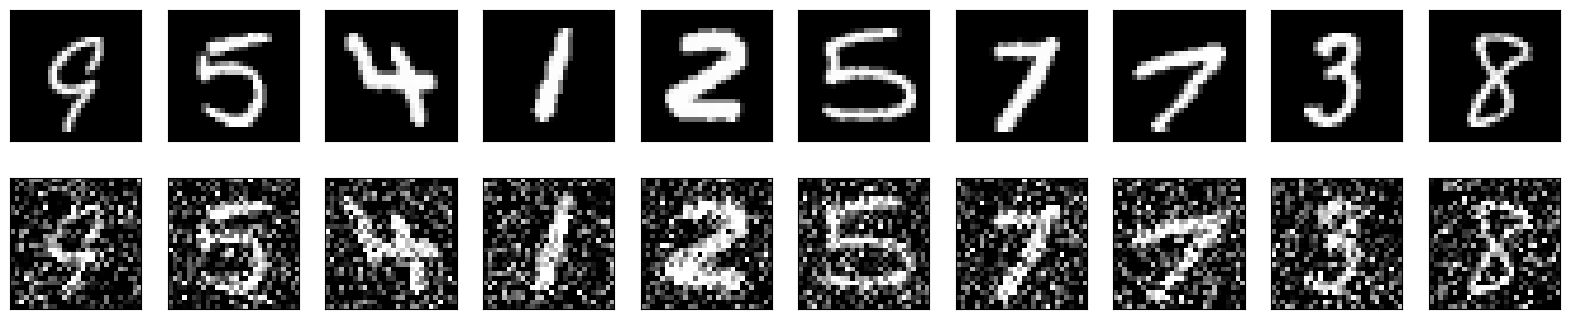

In [4]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [11]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 32)       9248

In [12]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10, # Originally 100, but 10 yielded similar enough results.
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1692 - val_loss: 0.1040
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1003 - val_loss: 0.0967
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0962 - val_loss: 0.0941
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0941 - val_loss: 0.0925
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0927 - val_loss: 0.0915
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0916 - val_loss: 0.0904
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0908 - val_loss: 0.0898
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0901 - val_loss: 0.0892
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0895 - val_loss: 0.0887
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0891 - val_loss: 0.0883

313/313 [==============================] - 0s 1ms/step


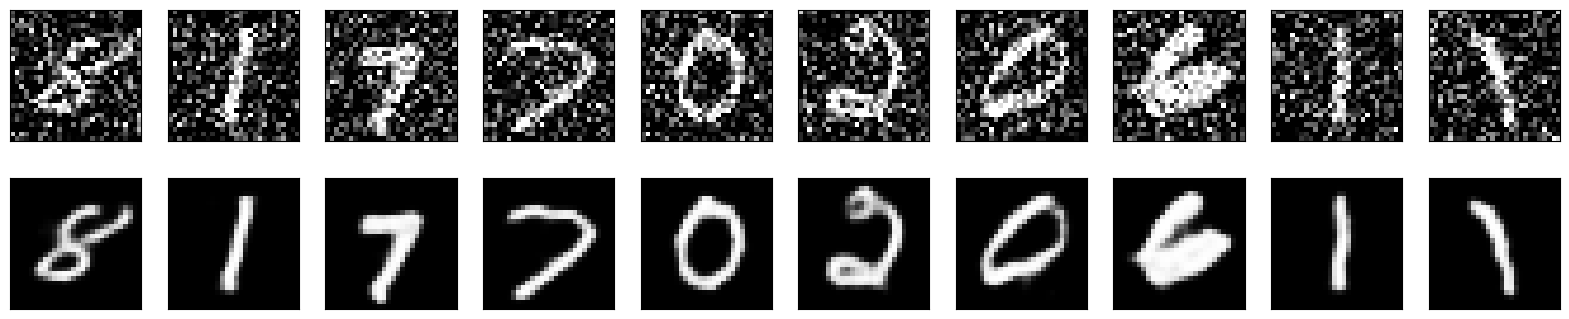

In [13]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)